## Convolution in the Fourier Space is called Spectral Convolution. The higher modes contains the global information. The lower modes refer to smaller frequencies.
## The FNO Block: $b = activation(ã + Conv_{1 * 1}(a))$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from timeit import default_timer
import scipy

In [2]:
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2025-03-02 00:19:39--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.61.183.122
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.61.183.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  4.09MB/s    in 2m 35s  

2025-03-02 00:22:15 (3.98 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [3]:
import numpy as np
data1 = np.load('/home/rvk/1D_Burgers_Nu0.001/tensor.npy')
print(data1.shape)

MemoryError: Unable to allocate 7.67 GiB for an array with shape (2058240000,) and data type float32

In [3]:
data = scipy.io.loadmat('/content/burgers_data_R10.mat')

In [4]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])


## The x-axis is corrected to go from 0 to 2 pi

In [34]:
a, u = data['a'], data['u']

In [35]:
#Add Channel Dimension
a = a[:, torch.newaxis, :]
u = u[:, torch.newaxis, :]

In [36]:
#Mesh is from 0 to 2 pi
mesh = np.linspace(0, 2*np.pi, u.shape[-1])

In [37]:
print(a[0][:10])

[[0.83541104 0.83534205 0.83527089 ... 0.83560509 0.83554256 0.83547788]]


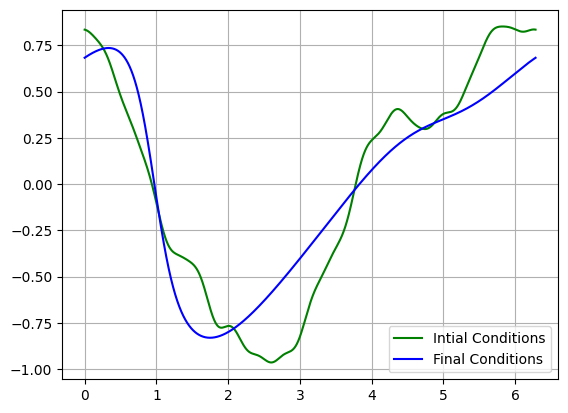

In [38]:
plt.plot(mesh, a[0][0], color = 'green', label = 'Intial Conditions')
plt.plot(mesh, u[0][0], color = 'blue', label = 'Final Conditions')
plt.grid()
plt.legend()
plt.show()

In [39]:
#Concatenate the mesh to a and u
mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis = 0)
print(mesh_shape_corrected.shape)

(2048, 1, 8192)


In [40]:
assert mesh_shape_corrected[0].sum() == mesh_shape_corrected[1].sum()

In [41]:
print(mesh.shape)

(8192,)


In [42]:
print(a.shape)

(2048, 1, 8192)


In [43]:
a_with_mesh = np.concatenate((a, mesh_shape_corrected), axis = 1)  # axis = 1 is the channel axis for a
print(a_with_mesh.shape)

(2048, 2, 8192)


In [44]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [45]:
print(train_x.shape, train_y.shape)

(1000, 2, 8192) (1000, 1, 8192)


In [46]:
print(np.fft.rfft(train_x[0]).shape)

(2, 4097)


In [47]:
real_part = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
imaginary_part = torch.tensor([[0.0, 1.0, 0.0], [4.0, 5.0, 6.0]])
complex_tensor = real_part + 1j * imaginary_part
print(complex_tensor)

tensor([[1.+0.j, 2.+1.j, 3.+0.j],
        [4.+4.j, 5.+5.j, 6.+6.j]])


## Fourier Neural Operator

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
import torch

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

NameError: name 'torch' is not defined

In [51]:
# Load the data
a, u = data["a"], data["u"]

# Add channel dimension
a = a[:, np.newaxis, :]
u = u[:, np.newaxis, :]

# Create mesh from 0 to 2π
mesh = np.linspace(0, 2 * np.pi, u.shape[-1])
mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)
a_with_mesh = np.concatenate((a, mesh_shape_corrected), axis=1)

# Prepare train/test split
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

# Convert to PyTorch tensors
train_x = torch.from_numpy(train_x).float().to(device)
train_y = torch.from_numpy(train_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device)
test_y = torch.from_numpy(test_y).float().to(device)

In [54]:
downsample_factor = 32
train_x_downsampled = train_x[..., ::downsample_factor]
train_y_downsampled = train_y[..., ::downsample_factor]
test_x_downsampled = test_x[..., ::downsample_factor]
test_y_downsampled = test_y[..., ::downsample_factor]
print(train_x_downsampled.shape, train_y_downsampled.shape)

torch.Size([1000, 2, 256]) torch.Size([1000, 1, 256])


In [55]:
train_dataset = TensorDataset(train_x_downsampled, train_y_downsampled)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [64]:
class SpectralConv1d(nn.Module):
  def __init__(self, in_channels, out_channels, modes1):
    super(SpectralConv1d, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes1 = modes1                 # Number of Fourier modes to multiply, at most floor(N/2) + 1

    self.scale = (1 / (in_channels*out_channels))
    self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

  # Complex multiplication
  def compl_mul1d(self, input, weights):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    return torch.einsum("bix,iox->box", input, weights)

  def forward(self, x):
    batchsize = x.shape[0]
    x_ft = torch.fft.rfft(x)

    out_ft = torch.zeros(
        batchsize,
        self.out_channels,
        x.size(-1)//2 + 1,
        device=x.device,
        dtype=torch.cfloat)
    out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1],
    self.weights1)

    x = torch.fft.irfft(out_ft, n=x.size(-1))
    return x

In [65]:
class FNOBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes, activation=F.relu):
        super(FNOBlock1d, self).__init__()
        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes)
        self.bypass_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.spectral_conv(x) + self.bypass_conv(x))

In [66]:
class FNO1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes, width, activation=F.relu, n_blocks=4):
        super(FNO1d, self).__init__()
        self.lifting = nn.Conv1d(in_channels, width, 1)

        self.fno_blocks = nn.ModuleList([
            FNOBlock1d(width, width, modes, activation) for _ in range(n_blocks)])

        self.projection = nn.Conv1d(width, out_channels, 1)

    def forward(self, x):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)
        return x

In [67]:
model = FNO1d(
    in_channels=2,
    out_channels=1,
    modes=16,
    width=64,
    n_blocks=4).to(device)

In [68]:
def train(model, train_loader, optimizer, epochs=200):
    model.train()
    loss_history = []
    val_loss_history = []
    l2_loss_history = []
    h1_loss_history = []

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()

            pred_y = model(batch_x)

            # L2 loss (standard MSE)
            l2_loss = F.mse_loss(pred_y, batch_y)

            # H1 loss (Sobolev norm)
            # Compute spatial gradients using finite differences
            # For x-direction gradients (assuming the spatial dimension is the last dimension)
            # Calculate dx spacing based on mesh
            dx = torch.tensor(2 * np.pi / pred_y.shape[-1], device=device)

            pred_grad_x = (pred_y[..., 1:] - pred_y[..., :-1]) / dx
            target_grad_x = (batch_y[..., 1:] - batch_y[..., :-1]) / dx
            grad_x_loss = F.mse_loss(pred_grad_x, target_grad_x)

            # Combine L2 and H1 losses
            # Using weights wx=wy=0.5 to balance function values and derivatives
            wx = wy = 0.5
            h1_loss = wx * wy * grad_x_loss
            loss = l2_loss + h1_loss

            # Track individual loss components
            l2_loss_item = l2_loss.item()
            h1_loss_item = h1_loss.item()

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(test_x_downsampled)

            # Compute L2 validation loss
            val_l2_loss = F.mse_loss(val_pred, test_y_downsampled)

            # Compute H1 validation loss component
            val_pred_grad_x = (val_pred[..., 1:] - val_pred[..., :-1])
            val_target_grad_x = (test_y_downsampled[..., 1:] - test_y_downsampled[..., :-1])
            val_grad_x_loss = F.mse_loss(val_pred_grad_x, val_target_grad_x)

            # Combined validation loss
            wx = wy = 0.5
            val_h1_loss = wx * wy * val_grad_x_loss
            val_loss = val_l2_loss + val_h1_loss
            val_loss_history.append(val_loss.item())
        model.train()

        # Track epoch losses
        loss_history.append(epoch_loss / len(train_loader))
        l2_loss_history.append(l2_loss_item)
        h1_loss_history.append(h1_loss_item)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss_history[-1]:.6f}, " +
                  f"L2 Loss: {l2_loss_item:.6f}, H1 Loss: {h1_loss_item:.6f}, " +
                  f"Val Loss: {val_loss_history[-1]:.6f}")

    return loss_history, val_loss_history, l2_loss_history, h1_loss_history

In [69]:
# Relative L2 norm error calculation
def relative_l2_norm(pred, ref):
    diff_norm = torch.norm(pred - ref)
    ref_norm = torch.norm(ref)
    return diff_norm / ref_norm

In [70]:
# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Train the model
train_loss, val_loss, l2_loss_history, h1_loss_history = train(model, train_loader, optimizer)

  6%|▌         | 11/200 [00:01<00:20,  9.03it/s]

Epoch 10/200, Total Loss: 0.004946, L2 Loss: 0.000951, H1 Loss: 0.003312, Val Loss: 0.001036


 10%|█         | 21/200 [00:02<00:19,  9.15it/s]

Epoch 20/200, Total Loss: 0.001095, L2 Loss: 0.000160, H1 Loss: 0.000592, Val Loss: 0.000320


 16%|█▌        | 31/200 [00:03<00:20,  8.23it/s]

Epoch 30/200, Total Loss: 0.000565, L2 Loss: 0.000098, H1 Loss: 0.000363, Val Loss: 0.000175


 20%|██        | 41/200 [00:04<00:18,  8.43it/s]

Epoch 40/200, Total Loss: 0.000411, L2 Loss: 0.000105, H1 Loss: 0.000370, Val Loss: 0.000126


 26%|██▌       | 51/200 [00:05<00:16,  9.07it/s]

Epoch 50/200, Total Loss: 0.000286, L2 Loss: 0.000043, H1 Loss: 0.000252, Val Loss: 0.000098


 30%|███       | 61/200 [00:06<00:15,  9.10it/s]

Epoch 60/200, Total Loss: 0.000239, L2 Loss: 0.000048, H1 Loss: 0.000242, Val Loss: 0.000079


 36%|███▌      | 71/200 [00:08<00:14,  9.08it/s]

Epoch 70/200, Total Loss: 0.000205, L2 Loss: 0.000027, H1 Loss: 0.000174, Val Loss: 0.000075


 40%|████      | 81/200 [00:09<00:13,  9.04it/s]

Epoch 80/200, Total Loss: 0.000167, L2 Loss: 0.000028, H1 Loss: 0.000174, Val Loss: 0.000060


 46%|████▌     | 91/200 [00:10<00:11,  9.12it/s]

Epoch 90/200, Total Loss: 0.000177, L2 Loss: 0.000019, H1 Loss: 0.000139, Val Loss: 0.000062


 50%|█████     | 101/200 [00:11<00:10,  9.10it/s]

Epoch 100/200, Total Loss: 0.000138, L2 Loss: 0.000022, H1 Loss: 0.000141, Val Loss: 0.000060


 56%|█████▌    | 111/200 [00:12<00:09,  9.09it/s]

Epoch 110/200, Total Loss: 0.000143, L2 Loss: 0.000017, H1 Loss: 0.000115, Val Loss: 0.000051


 60%|██████    | 121/200 [00:13<00:08,  9.02it/s]

Epoch 120/200, Total Loss: 0.000424, L2 Loss: 0.000170, H1 Loss: 0.000331, Val Loss: 0.000361


 66%|██████▌   | 131/200 [00:14<00:07,  8.99it/s]

Epoch 130/200, Total Loss: 0.000232, L2 Loss: 0.000029, H1 Loss: 0.000127, Val Loss: 0.000065


 70%|███████   | 141/200 [00:15<00:07,  8.34it/s]

Epoch 140/200, Total Loss: 0.000169, L2 Loss: 0.000037, H1 Loss: 0.000174, Val Loss: 0.000056


 76%|███████▌  | 151/200 [00:17<00:05,  8.93it/s]

Epoch 150/200, Total Loss: 0.000096, L2 Loss: 0.000012, H1 Loss: 0.000087, Val Loss: 0.000043


 80%|████████  | 161/200 [00:18<00:04,  9.01it/s]

Epoch 160/200, Total Loss: 0.000096, L2 Loss: 0.000016, H1 Loss: 0.000099, Val Loss: 0.000050


 86%|████████▌ | 171/200 [00:19<00:03,  9.14it/s]

Epoch 170/200, Total Loss: 0.000100, L2 Loss: 0.000013, H1 Loss: 0.000075, Val Loss: 0.000047


 90%|█████████ | 181/200 [00:20<00:02,  9.07it/s]

Epoch 180/200, Total Loss: 0.000138, L2 Loss: 0.000038, H1 Loss: 0.000122, Val Loss: 0.000046


 96%|█████████▌| 191/200 [00:21<00:00,  9.05it/s]

Epoch 190/200, Total Loss: 0.000350, L2 Loss: 0.000094, H1 Loss: 0.000257, Val Loss: 0.000111


100%|██████████| 200/200 [00:22<00:00,  8.93it/s]

Epoch 200/200, Total Loss: 0.000139, L2 Loss: 0.000020, H1 Loss: 0.000116, Val Loss: 0.000055


Mean Relative L2 Error: 0.013701


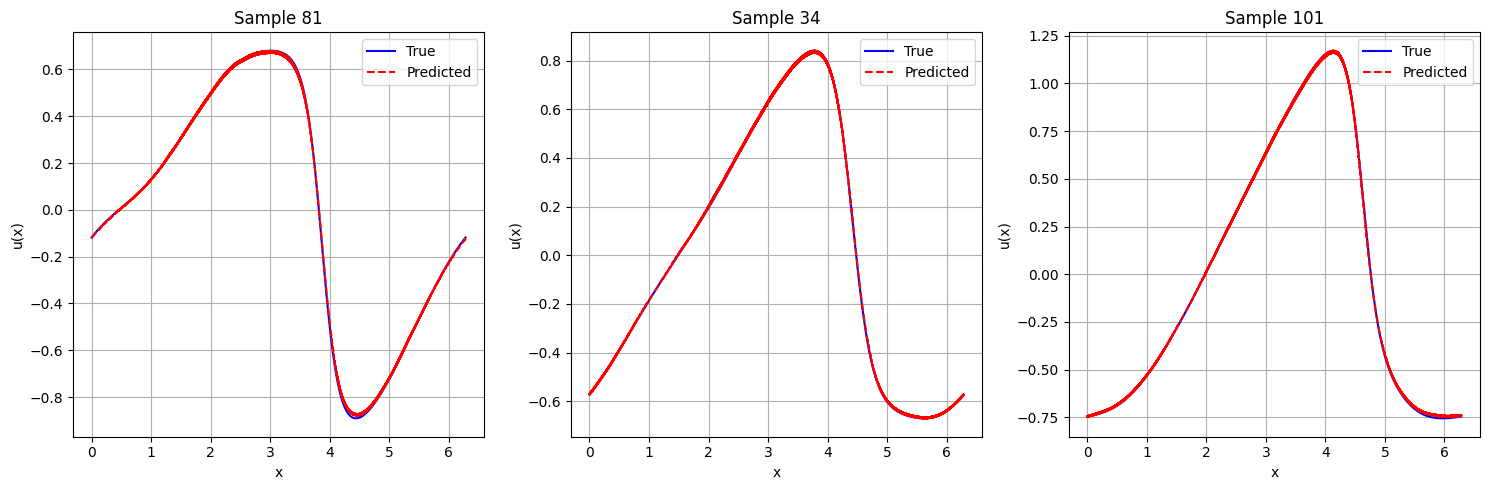

In [72]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    test_pred = model(test_x)

    # Calculate relative L2 error for each sample
    rel_l2_errors = torch.zeros(test_y.shape[0])
    for i in range(test_y.shape[0]):
        rel_l2_errors[i] = relative_l2_norm(test_pred[i], test_y[i])

    mean_error = rel_l2_errors.mean().item()
    print(f"Mean Relative L2 Error: {mean_error:.6f}")

# Visualize some predictions
plt.figure(figsize=(15, 5))
sample_idx = np.random.randint(0, test_x.shape[0], 3)
x_axis = np.linspace(0, 2*np.pi, test_y.shape[-1])

for i, idx in enumerate(sample_idx):
    plt.subplot(1, 3, i+1)
    plt.plot(x_axis, test_y[idx, 0].cpu().numpy(), 'b-', label='True')
    plt.plot(x_axis, test_pred[idx, 0].cpu().numpy(), 'r--', label='Predicted')
    plt.title(f'Sample {idx}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('fno_predictions.png')
plt.show()

In [4]:
!pip3 install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.7 MB/s eta 0:00:00


In [6]:
import h5py
import os
import numpy as np

os.makedirs('2D_DarcyFlow_beta0.1', exist_ok=True)

with h5py.File('darcy_flow_data.h5', 'r') as f:
    for key in f.keys():
        data = f[key][()]
        np.save(f'2D_DarcyFlow_beta0.1/{key}.npy', data)
        print(f"Saved {key} with shape {data.shape}")
        
        print(f"Dataset: {key}")
        print(f"  Shape: {data.shape}")
        print(f"  Type: {data.dtype}")
        print(f"  Size: {data.size} elements")
        print()


Saved nu with shape (10000, 128, 128)
Dataset: nu
  Shape: (10000, 128, 128)
  Type: float32
  Size: 163840000 elements

Saved tensor with shape (10000, 1, 128, 128)
Dataset: tensor
  Shape: (10000, 1, 128, 128)
  Type: float32
  Size: 163840000 elements

Saved x-coordinate with shape (128,)
Dataset: x-coordinate
  Shape: (128,)
  Type: float32
  Size: 128 elements

Saved y-coordinate with shape (128,)
Dataset: y-coordinate
  Shape: (128,)
  Type: float32
  Size: 128 elements



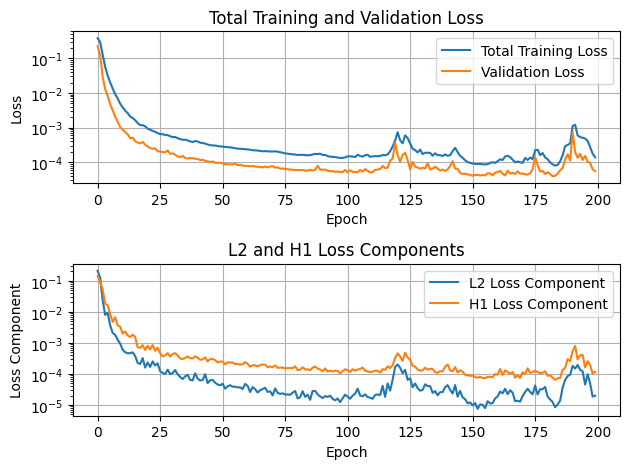

In [71]:
# Plot 1: Overall losses
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Total Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Training and Validation Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)

# Plot 2: Loss components
plt.subplot(2, 1, 2)
plt.plot(l2_loss_history, label='L2 Loss Component')
plt.plot(h1_loss_history, label='H1 Loss Component')
plt.xlabel('Epoch')
plt.ylabel('Loss Component')
plt.title('L2 and H1 Loss Components')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.savefig('fno_loss_curve.png')
plt.show()

In [13]:
%pwd

'/home/rvk/CNO/CNO2d_original_version'

In [15]:
%cd .. 

/home/rvk


In [30]:
%pwd

'/home/rvk'

In [5]:
%cd CNO/CNO2d_original_version

/home/rvk/CNO/CNO2d_original_version


In [6]:
%ls

CNOModule.py                             Problems/       readme.md
Error_Distribution.py                    TrainCNO.py     torch_utils/
Error_Distribution_VaryingResolution.py  __pycache__/    training/
LICENSE_NVIDIA.txt                       debug_tools.py
ModelSelectionCNO.py                     dnnlib/


In [ ]:
!pip3 install requests

In [29]:
from CNOModule import CNOBlock, CNO

In [31]:
from CNO.CNO2d_original_version.CNOModule import CNO

In [12]:
import torch

model = CNOBlock(
    in_channels=3,      
    out_channels=3,    
    in_size=32,        
    out_size=32,       
    cutoff_den=2.0001,  
    conv_kernel=3,      
    filter_size=6,      # Filter size for anti-aliasing
    batch_norm=True,   
    activation='cno_lrelu'  
)


x = torch.randn(2, 3, 32, 32)  
output = model(x)

In [32]:
import torch

# Create the full CNO model
model = CNO(
    in_dim=3,                    # Input channels (e.g., RGB or velocity components)
    in_size=32,                  # Spatial resolution (32x32)
    out_dim=3,                   # Output channels 
    out_size=1,                  # Keep same size as input (out_size=1 means out_size=in_size)
    N_layers=3,                  # Number of down/up sampling layers
    N_res=4,                     # Residual blocks per level
    N_res_neck=6,                # Residual blocks in bottleneck
    channel_multiplier=32,       # Channel growth factor
    conv_kernel=3,
    cutoff_den=2.0001,
    filter_size=6,
    lrelu_upsampling=2,
    half_width_mult=0.8,
    radial=False,
    batch_norm=True,
    expand_input=False,
    latent_lift_proj_dim=64,
    add_inv=True,
    activation='cno_lrelu'
).to('cpu')

# Test with your data shape
x = torch.randn(2, 3, 32, 32)  # [batch, channels, height, width]
output = model(x)              # Should output [2, 3, 32, 32]

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Model parameters: {model.get_n_params():,}")

Input shape: torch.Size([2, 3, 32, 32])
Output shape: torch.Size([2, 3, 32, 32])
Model parameters: 2,953,555


In [13]:
print(output.shape)

torch.Size([2, 3, 32, 32])


In [9]:
import torch


model = CNO(
    in_dim=3,
    in_size=32,
    out_dim=3,
    N_layers=1,           # Minimal depth
    N_res=1,              # Minimal residual blocks
    N_res_neck=1,         # Minimal neck
    channel_multiplier=8, # Small channels
    activation='lrelu'    # Simpler activation
).to('cpu')  # Force CPU

x = torch.randn(1, 3, 32, 32)  # Single sample
with torch.no_grad():  # No gradients for testing
    output = model(x)
    
print(f"Success! Output shape: {output.shape}")

Success! Output shape: torch.Size([1, 3, 32, 32])
